In [ ]:
!pip install transformers pytorch-crf==0.7.2 torchmetrics

In [ ]:
import csv
import sys
import os
import collections
import random
from tqdm import trange,tqdm

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, Subset
from transformers import BasicTokenizer, BertPreTrainedModel, BertModel, BertConfig,  BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
import numpy as np
from torch import nn
from torchcrf import CRF
import torchmetrics
from torchmetrics import Metric

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/My Drive/NLPProjectWork/data/neoplasm'
if os.path.exists(data_dir):
    os.chdir(data_dir)
    print(f"Current directory: {os.getcwd()}")
else:
    print("Directory not found.")

Current directory: /content/drive/My Drive/NLPProjectWork/data/neoplasm


In [ ]:
def set_seed(seed, n_gpu):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(seed)

In [ ]:
n_gpu = torch.cuda.device_count()
set_seed(seed = 2, n_gpu = n_gpu)

# 1. Preprocessing



In [ ]:
class InputExample(object):
    def __init__(self, guid, text, labels=None):
        self.guid = guid
        self.text = text
        self.labels = labels


class InputFeatures(object):
    def __init__(self, input_ids, input_mask, segment_ids, label_ids, label_proba):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids
        self.label_proba = label_proba

In [ ]:
class DataProcessor(object):
    def __init__(self):
        self.labels = ["X", "B-Claim", "I-Claim", "B-Premise", "I-Premise", 'O']
        self.label_map = self._create_label_map()
        self.replace_labels = {
            'B-MajorClaim': 'B-Claim',
            'I-MajorClaim': 'I-Claim',
        }

    def _create_label_map(self):
        label_map = collections.OrderedDict()
        for i, label in enumerate(self.labels):
            label_map[label] = i
        return label_map

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self.read_conll(os.path.join(data_dir, "train.conll"), replace=self.replace_labels), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self.read_conll(os.path.join(data_dir, "dev.conll"), replace=self.replace_labels), "dev")

    def get_test_examples(self, data_dir, setname="test.conll"):
        """See base class."""
        return self._create_examples(
            self.read_conll(os.path.join(data_dir, setname), replace=self.replace_labels), "test")

    def get_labels(self):
        """ See base class."""
        return self.labels

    def convert_labels_to_ids(self, labels):
        idx_list = []
        for label in labels:
            idx_list.append(self.label_map[label])
        return idx_list

    def convert_ids_to_labels(self, idx_list):
        labels_list = []
        for idx in idx_list:
            labels_list.append([key for key in self.label_map.keys() if self.label_map[key] == idx][0])
        return labels_list

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, str(i))
            text = line[0]
            labels = line[-1]
            examples.append(
                InputExample(guid=guid, text=text, labels=labels))
        return examples

    def convert_examples_to_features(self, examples, max_seq_length, tokenizer,
                                     cls_token='[CLS]',
                                     sep_token='[SEP]'):
        """Loads a data file into a list of `InputBatch`s."""

        features = []
        for (ex_index, example) in enumerate(examples):
            tokens_a, labels = tokenizer.tokenize_with_label_extension(example.text, example.labels,
                                                                       copy_previous_label=True)

            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]
                labels = labels[:(max_seq_length - 2)]
            labels = ["X"] + labels + ["X"]

            tokens = [cls_token] + tokens_a + [sep_token]
            segment_ids = [0] * len(tokens)
            input_ids = tokenizer.convert_tokens_to_ids(tokens)
            # The mask has 1 for real tokens and 0 for padding tokens. Only real
            # tokens are attended to.
            input_mask = [1] * len(input_ids)
            # Zero-pad up to the sequence length.
            padding = [0] * (max_seq_length - len(input_ids))
            input_ids += padding
            input_mask += padding
            segment_ids += padding
            label_ids = self.convert_labels_to_ids(labels)
            label_proba = self.compute_label_probadist(label_ids)
            label_ids += padding

            assert len(label_ids) == max_seq_length
            assert len(input_ids) == max_seq_length
            assert len(input_mask) == max_seq_length
            assert len(segment_ids) == max_seq_length

            features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=label_ids,
                              label_proba=label_proba))
        return features

    def compute_label_probadist(self, label_ids, mask=None):
        label_ids_np = np.array(label_ids)
        if mask is not None:
            mask_np = mask.cpu().detach().numpy()
            label_ids_np = label_ids_np[mask_np == 1]
        label_ids_np = label_ids_np[1:-1]
        label_ids_np = label_ids_np[label_ids_np != 0]
        if len(label_ids_np) == 0:
            return [0.0, 0.0, 0.0]
        assert (0 not in label_ids_np)
        map = {self.label_map["B-Claim"]: 0,
               self.label_map["I-Claim"]: 0,
               self.label_map["B-Premise"]: 1,
               self.label_map["I-Premise"]: 1,
               self.label_map["O"]: 2}
        remapped_label_ids = [map[label] for label in label_ids_np]
        counts = np.bincount(remapped_label_ids, minlength=3)
        probabilities = counts / len(remapped_label_ids)
        return probabilities

    @classmethod
    def features_to_dataset(cls, feature_list):
        all_input_ids = torch.tensor([f.input_ids for f in feature_list], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in feature_list], dtype=torch.uint8)
        all_segment_ids = torch.tensor([f.segment_ids for f in feature_list], dtype=torch.long)
        all_label_ids = torch.tensor([f.label_ids for f in feature_list], dtype=torch.long)
        all_label_probas = torch.tensor([np.array(f.label_proba) for f in feature_list])
        dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids, all_label_probas)
        return dataset

    @classmethod
    def read_conll(cls, input_file, token_number=0, token_column=1, label_column=4, replace=None):
        """Reads a conll type file."""
        with open(input_file, "r", encoding='utf-8') as f:
            lines = f.readlines()
            sentences = []
            tokenizer = BasicTokenizer()
            sent_tokens = []
            sent_labels = []

            for idx, line in enumerate(lines):
                line = line.split('\t')
                # Skip the lines in which there is /n
                if len(line) < 2:
                    continue

                # Controllare se sono all'ID numero 1, assicurandomi nel mentre che NON sia la prima iterazione
                if idx != 0 and int(line[token_number]) == 0:
                    assert len(sent_tokens) == len(sent_labels)
                    if replace:
                        sent_labels = [replace[label] if label in replace.keys() else label for label in sent_labels]
                    sentences.append([' '.join(sent_tokens), sent_labels])
                    sent_tokens = []
                    sent_labels = []

                token = line[token_column]
                label = line[label_column].replace('\n', '')
                tokenized = tokenizer.tokenize(token)

                if len(tokenized) > 1:
                    for i in range(len(tokenized)):
                        sent_tokens.append(tokenized[i])
                        sent_labels.append(label)
                else:
                    sent_tokens.append(tokenized[0])
                    sent_labels.append(label)
            if sent_tokens != []:
                assert len(sent_tokens) == len(sent_labels)
                if replace:
                    sent_labels = [replace[label] if label in replace.keys() else label for label in sent_labels]
                sentences.append([' '.join(sent_tokens), sent_labels])
        return sentences

    def load_examples(self, data_dir, max_seq_length, tokenizer, evaluate=False, isval=False):
        if evaluate:
            examples = self.get_test_examples(data_dir)
        elif isval:
            examples = self.get_dev_examples(data_dir)
        else:
            examples = self.get_train_examples(data_dir)
        features = self.convert_examples_to_features(examples, max_seq_length=max_seq_length, tokenizer=tokenizer)
        dataset = self.features_to_dataset(features)
        return dataset

In [ ]:
class ExtendedBertTokenizer:
    """Extended tokenizer that wraps a base tokenizer."""

    def __init__(self, base_tokenizer):
        self.tokenizer = base_tokenizer

    def tokenize_with_label_extension(self, text, labels, copy_previous_label=False, extension_label='X'):
        tok_text = self.tokenizer.tokenize(text)
        for i in range(len(tok_text)):
            if '##' in tok_text[i]:
                if copy_previous_label:
                    labels.insert(i, labels[i - 1])
                else:
                    labels.insert(i, extension_label)
        return tok_text, labels

    def convert_tokens_to_ids(self, tokens):
      return self.tokenizer.convert_tokens_to_ids(tokens)

# 2. Models

In [ ]:
class BertForSequenceTagging(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.rnn = nn.GRU(config.hidden_size, config.hidden_size, batch_first=True, bidirectional=True)
        self.crf = CRF(config.num_labels, batch_first=True)
        self.classifier = nn.Linear(2 * config.hidden_size, config.num_labels)
        self.custom_init_weights()
        self.name = "seq_tag_model"

    def custom_init_weights(self):
        # Initialize weights of GRU
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param, gain=0.01)
            elif 'bias' in name:
                nn.init.zeros_(param)
        nn.init.xavier_uniform_(self.crf.start_transitions)
        nn.init.xavier_uniform_(self.crf.end_transitions)
        nn.init.xavier_uniform_(self.crf.transitions)
        nn.init.xavier_uniform_(self.classifier.weight)
        if self.classifier.bias is not None:
            nn.init.zeros_(self.classifier.bias)
    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            labels=None,
            labels_proba=None
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        sequence_output = outputs[0]
        rnn_out, _ = self.rnn(sequence_output)
        emissions = self.classifier(rnn_out)
        emissions = emissions / 10
        mask = attention_mask.bool()
        log_likelihood = self.crf(emissions, labels, mask=mask)
        path = self.crf.decode(emissions)
        path = torch.LongTensor(path)
        return (-1 * log_likelihood, emissions, path, None)

Possible implementation of two heads model, that predicts both POS Taggin labels and the probability distribution.

In [ ]:
class ClassificationAndCounting:
    def __init__(self, learner, processor: DataProcessor):
        self.learner = learner
        self.processor = processor
        self.name = "bert_classify_and_count"

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            labels=None,
            labels_proba=None
    ):

        loss, emissions, path, _ = self.learner(input_ids, attention_mask, token_type_ids, labels, labels_proba)

        proba_dists = self.aggregate(path, attention_mask)
        return loss, emissions, path, proba_dists

    def aggregate(self, predictions, attention_mask):
        all_probabilities = []
        for sequence, mask in zip(predictions, attention_mask):
            label_proba = self.processor.compute_label_probadist(sequence, mask=mask)
            all_probabilities.append(label_proba)
        return np.array(all_probabilities)

    def train(self, mode=True):
        self.learner.train(mode)

    def eval(self):
        self.learner.eval()

    def state_dict(self, *args, **kwargs):
        return self.learner.state_dict(*args, **kwargs)

    def load_state_dict(self, *args, **kwargs):
        return self.learner.load_state_dict(*args, **kwargs)

    def to(self, *args, **kwargs):
        self.learner.to(*args, **kwargs)

    def parameters(self):
        return self.learner.parameters()

    def named_parameters(self):
        return self.learner.named_parameters()

    def zero_grad(self):
        self.learner.zero_grad()

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [ ]:
class BertForLabelDistribution(BertPreTrainedModel):
    def __init__(self, config, loss_fn, loss_fn_name):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.rnn = nn.GRU(config.hidden_size, config.hidden_size, batch_first=True, bidirectional=True)
        self.classifier = nn.Linear(2 * config.hidden_size, config.num_labels)
        self.softmax = nn.Softmax(dim=-1)
        self.init_weights()
        self.loss_fn = loss_fn
        self.name = f"bert_quantify_{loss_fn_name}"
        self.custom_init_weights()

    def custom_init_weights(self):
        # Initialize weights of GRU
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param, gain=0.01)
            elif 'bias' in name:
                nn.init.zeros_(param)  # Initialize biases to zero

        # Initialize weights of the classifier
        nn.init.xavier_uniform_(self.classifier.weight)
        if self.classifier.bias is not None:
            nn.init.zeros_(self.classifier.bias)

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            labels=None,
            labels_proba=None,
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        sequence_output = outputs[0]  # [batch_size, seq_len, hidden_size]
        rnn_out, _ = self.rnn(sequence_output)  # [batch_size, seq_len, 2*hidden_size]
        emissions = self.classifier(rnn_out)  # [batch_size, seq_len, num_labels]
        cls_emissions = emissions[:, 0, :]  # [batch_size, num_labels]
        cls_probs = self.softmax(cls_emissions)  # [batch_size, num_labels]
        loss = self.loss_fn(cls_probs, labels_proba)
        return loss, emissions, None, cls_probs

In [ ]:
class BertForSequenceTaggingAndQuantification(BertPreTrainedModel):
    def __init__(self, config, distribution_loss_fn, loss_fn_name):
        super().__init__(config, lambda_tagging=0.0001, lambda_distribution=1.0)
        self.num_labels = config.num_labels
        self.num_proba_labels = 3

        self.bert = BertModel(config)
        self.rnn = nn.GRU(config.hidden_size, config.hidden_size, batch_first=True, bidirectional=True)
        self.crf = CRF(config.num_labels, batch_first=True)
        self.classifier = nn.Linear(2 * config.hidden_size, config.num_labels)  # For sequence tagging

        # For the quantification task
        self.projection_head = nn.Sequential(
            nn.Linear(config.num_labels * config.max_length, 128),  # Concatenate emissions across sequence
            nn.ReLU(),                                                  # Non-linear activation
            nn.Linear(128, self.num_proba_labels)  # Output 3 classes (Claim, Premise, Outside)
        )
        self.distribution_loss_fn = distribution_loss_fn
        self.lambda_tagging = 0.0001
        self.lambda_distribution = 1.0

        self.custom_init_weights()
        self.name = f"seq_tag_quant_model_{loss_fn_name}"

    def custom_init_weights(self):
        # Initialize weights of GRU
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param, gain=0.01)
            elif 'bias' in name:
                nn.init.zeros_(param)  # Initialize biases to zero

        # Initialize weights of CRF transitions
        nn.init.normal_(self.crf.start_transitions, mean=0, std=0.1)
        nn.init.normal_(self.crf.end_transitions, mean=0, std=0.1)
        nn.init.normal_(self.crf.transitions, mean=0, std=0.1)

        # Initialize weights of the classifier
        nn.init.xavier_uniform_(self.classifier.weight)
        if self.classifier.bias is not None:
            nn.init.zeros_(self.classifier.bias)

        # Initialize weights of the projection head
        for layer in self.projection_head:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

    def forward(
            self,
            input_ids=None,
            attention_mask=None,
            token_type_ids=None,
            labels=None,
            labels_proba=None  # True distribution of Claim, Premise, Outside
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        sequence_output = outputs[0]  # Shape: (batch_size, sequence_length, hidden_size)
        rnn_out, _ = self.rnn(sequence_output)  # Shape: (batch_size, sequence_length, 2 * hidden_size)
        emissions = self.classifier(rnn_out)    # Shape: (batch_size, sequence_length, num_labels)
        mask = attention_mask.bool()
        log_likelihood = self.crf(emissions, labels, mask=mask)  # Sequence tagging loss
        path = self.crf.decode(emissions)  # CRF-decoded sequence
        path = torch.LongTensor(path)

        # Part 2: Quantification (Predict probability distribution)
        # 1. Flatten emissions along the sequence dimension
        flattened_emissions = emissions.view(emissions.size(0), -1)  # Concatenates emissions along sequence
        # 2. Non-linear projection to 3-class probability distribution
        predicted_distribution = self.projection_head(flattened_emissions)  # Shape: (batch_size, num_proba_labels)
        # 3. Apply softmax to get a valid probability distribution
        predicted_distribution = nn.Softmax(dim=-1)(predicted_distribution)
        distribution_loss = None
        # Use Kullback-Leibler divergence or Mean Absolute Error
        distribution_loss = self.distribution_loss_fn(predicted_distribution.log(), labels_proba)
        total_loss =self.lambda_tagging* -log_likelihood + self.lambda_distribution * distribution_loss  # Sequence tagging loss
        return (total_loss, emissions, path, predicted_distribution)


# 3. Train/Evaluate

In [ ]:
def get_quantization_preds_labels(inputs, outputs):
    _, _, _, pred_proba = outputs
    pred_proba = torch.tensor(pred_proba).to(device)
    labels_proba = inputs["labels_proba"]
    return pred_proba,labels_proba

def get_classf_preds_labels(inputs, outputs):
    loss, emissions, path, _ = outputs
    batch_logits = path.detach().cpu().numpy().flatten()
    batch_labels = inputs["labels"].detach().cpu().numpy().flatten()
    attention_mask = inputs["attention_mask"].detach().cpu().numpy().flatten()
    valid_batch_logits = batch_logits[attention_mask == 1]
    valid_batch_labels = batch_labels[attention_mask == 1]
    return torch.tensor(valid_batch_logits), torch.tensor(valid_batch_labels)

def mae_loss(pred_probas, label_probas):
    loss = nn.L1Loss(reduction="mean")
    return loss(pred_probas, label_probas)

def kldiv_loss(pred_probas, label_probas):
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    pred_probas_log = torch.log(pred_probas)
    output = kl_loss(pred_probas_log, label_probas)
    return output

def process_batch(batch, device, model, gen_preds_labels_fn, eval=False):
    model.eval() if eval else model.train()
    batch = tuple(t.to(device) for t in batch)
    inputs = {"input_ids": batch[0], "attention_mask": batch[1], "token_type_ids": batch[2], "labels": batch[3],
              "labels_proba": batch[4]}
    with torch.no_grad() if eval else torch.enable_grad():
        outputs = model(**inputs)
    preds, labels = gen_preds_labels_fn(inputs, outputs)
    return outputs, preds, labels

In [ ]:
def evaluate(device, model, eval_dataset, eval_batch_size, metrics, gen_preds_labels_fn):
    eval_dataloader = DataLoader(eval_dataset, batch_size=eval_batch_size)
    epoch_loss_sum = 0.0
    for metric in metrics:
        metric.reset()
    model.eval()
    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            outputs, preds, labels = process_batch(batch, device, model, gen_preds_labels_fn, eval=True)
            loss = outputs[0]
            epoch_loss_sum += loss.item()
            for metric in metrics:
                if metric.__class__.__name__ == "KLDivergence":
                      labels = labels.clamp(min=1e-9)
                      preds = preds.clamp(min=1e-9)
                metric.update(preds, labels)
    eval_loss = epoch_loss_sum / len(eval_dataloader)
    eval_metrics = {metric.__class__.__name__: metric.compute().item() for metric in metrics}
    return eval_loss, eval_metrics

In [ ]:
def update_metrics(history, metrics, metric_type, epoch):
    for metric_name, metric_value in metrics.items():
        if epoch == 0:
            history[metric_type][metric_name] = [metric_value]
        else:
            history[metric_type][metric_name].append(metric_value)
        print(f"{metric_name}: {metric_value:.4f}")
def train(
        device,
        train_dataset,
        model,
        eval_dataset,
        generate_preds_labels_fn,
        metrics,
        num_train_epochs=20,
        train_batch_size=1,
        eval_batch_size=32,
        weight_decay=0.1,
        learning_rate=2e-5,
        adam_epsilon=1e-8,
        warmup_steps=4,
        max_grad_norm = 3.0
):
    history = {
        'train_loss': [],
        'train_metrics': {},
        'eval_loss': [],
        'eval_metrics': {}
    }
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size)
    num_steps_per_epoch = len(train_dataloader)
    t_total = num_steps_per_epoch * num_train_epochs
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total
    )
    epochs_trained = 0

    train_iterator = trange(epochs_trained, int(num_train_epochs), desc="Epoch")
    print(f"TRAINING MODEL {model.name}")
    for epoch in train_iterator:
        epoch_loss_sum = 0.0
        epoch_iterator = tqdm(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            optimizer.zero_grad()
            outputs, preds, labels = process_batch(batch, device, model, generate_preds_labels_fn, eval=False)
            loss = outputs[0]
            #print(f"SINGLE LOSS: {loss}")
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            epoch_loss_sum += loss.item()
            for metric in metrics:
                if metric.__class__.__name__ == "KLDivergence":
                      labels = labels.clamp(min=1e-9)
                      preds = preds.clamp(min=1e-9)
                metric.update(preds, labels)
            optimizer.step()
            scheduler.step()
        epoch_loss = epoch_loss_sum / num_steps_per_epoch

        history['train_loss'].append(epoch_loss)
        epoch_metrics = {metric.__class__.__name__: metric.compute().item() for metric in metrics}
        eval_loss, eval_metrics = evaluate(device, model, eval_dataset, eval_batch_size, metrics,
                                           generate_preds_labels_fn)
        history['eval_loss'].append(eval_loss)
        print(f"Epoch {epoch + 1}/{num_train_epochs}")
        print(f"Train Loss: {epoch_loss:.4f}")
        update_metrics(history, epoch_metrics, 'train_metrics', epoch)
        print(f"Eval Loss: {eval_loss:.4f}")
        update_metrics(history, eval_metrics, 'eval_metrics', epoch)
    return history

In [ ]:
model_name_or_path = 'allenai/scibert_scivocab_uncased'
do_lower_case = True
base_tokenizer = BertTokenizer.from_pretrained(model_name_or_path, do_lower_case=do_lower_case)
extended_tokenizer = ExtendedBertTokenizer(base_tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataprocessor = DataProcessor()

Questa e' una quantita' cambiabile.

In [ ]:
max_seq_length = 510

In [ ]:
train_ds = dataprocessor.load_examples(data_dir=data_dir, max_seq_length=max_seq_length,
                        tokenizer=extended_tokenizer)
val_ds = dataprocessor.load_examples( data_dir=data_dir, max_seq_length=max_seq_length,
                        tokenizer=extended_tokenizer, isval=True)
test_ds = dataprocessor.load_examples(data_dir=data_dir, max_seq_length=max_seq_length,
                        tokenizer=extended_tokenizer, evaluate=True)
num_class_labels = len(dataprocessor.get_labels())


<ipython-input-9-fbad69c7ca63>:134: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  all_label_probas = torch.tensor([np.array(f.label_proba) for f in feature_list])


In [ ]:
class MAEForClaims(Metric):
    def __init__(self, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.add_state("sum_abs_error", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, targets: torch.Tensor):
        # Extract only the Claims (index 0)
        preds_claims = preds[:, 0]
        targets_claims = targets[:, 0]
        self.sum_abs_error += torch.sum(torch.abs(preds_claims - targets_claims))
        self.total += preds_claims.numel()

    def compute(self):
        return self.sum_abs_error / self.total


class MSEForClaims(Metric):
    def __init__(self, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.add_state("sum_squared_error", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, targets: torch.Tensor):
        # Extract only the Claims (index 0)
        preds_claims = preds[:, 0]
        targets_claims = targets[:, 0]
        self.sum_squared_error += torch.sum((preds_claims - targets_claims) ** 2)
        self.total += preds_claims.numel()

    def compute(self):
        return self.sum_squared_error / self.total

# Train "classification and count" model

In [ ]:
classify_count_config = BertConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_class_labels)
classify_count_base_model = BertForSequenceTagging.from_pretrained(
    model_name_or_path,
    config=classify_count_config
)
classify_and_count_model = ClassificationAndCounting(learner=classify_count_base_model, processor=dataprocessor)
classify_and_count_model.to(device)
dist_metrics = [torchmetrics.KLDivergence(log_prob=False, reduction="mean").to(device),
                torchmetrics.MeanAbsoluteError().to(device),
                torchmetrics.MeanSquaredError().to(device),
                MAEForClaims().to(device),
                MSEForClaims().to(device)]
history_classify_count = train(device=device, train_dataset=train_ds, model=classify_and_count_model, eval_dataset=val_ds, generate_preds_labels_fn=get_quantization_preds_labels, metrics=dist_metrics)

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceTagging were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'crf.end_transitions', 'crf.start_transitions', 'crf.transitions', 'rnn.bias_hh_l0', 'rnn.bias_hh_l0_reverse', 'rnn.bias_ih_l0', 'rnn.bias_ih_l0_reverse', 'rnn.weight_hh_l0', 'rnn.weight_hh_l0_reverse', 'rnn.weight_ih_l0', 'rnn.weight_ih_l0_reverse']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

TRAINING MODEL bert_classify_and_count



Iteration:   0%|          | 0/350 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:530.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)

Iteration: 100%|██████████| 350/350 [04:20<00:00,  1.34it/s]

Epoch:   5%|▌         | 1/20 [04:22<1:23:16, 263.00s/it]

Epoch 1/20
Train Loss: 295.0080
KLDivergence: 0.0916
MeanAbsoluteError: 0.0738
MeanSquaredError: 0.0137
MAEForClaims: 0.0628
MSEForClaims: 0.0079
Eval Loss: 4135.0267
KLDivergence: 0.0406
MeanAbsoluteError: 0.0361
MeanSquaredError: 0.0040
MAEForClaims: 0.0338
MSEForClaims: 0.0032



Iteration: 100%|██████████| 350/350 [04:21<00:00,  1.34it/s]

Epoch:  10%|█         | 2/20 [08:47<1:19:06, 263.70s/it]

Epoch 2/20
Train Loss: 159.4845
KLDivergence: 0.0326
MeanAbsoluteError: 0.0395
MeanSquaredError: 0.0044
MAEForClaims: 0.0343
MSEForClaims: 0.0030
Eval Loss: 3557.2180
KLDivergence: 0.0258
MeanAbsoluteError: 0.0346
MeanSquaredError: 0.0038
MAEForClaims: 0.0379
MSEForClaims: 0.0047



Iteration: 100%|██████████| 350/350 [04:16<00:00,  1.36it/s]

Epoch:  15%|█▌        | 3/20 [13:06<1:14:06, 261.57s/it]

Epoch 3/20
Train Loss: 135.7669
KLDivergence: 0.0280
MeanAbsoluteError: 0.0352
MeanSquaredError: 0.0038
MAEForClaims: 0.0311
MSEForClaims: 0.0030
Eval Loss: 3960.2609
KLDivergence: 0.0348
MeanAbsoluteError: 0.0507
MeanSquaredError: 0.0066
MAEForClaims: 0.0423
MSEForClaims: 0.0041



Iteration: 100%|██████████| 350/350 [04:16<00:00,  1.37it/s]

Epoch:  20%|██        | 4/20 [17:24<1:09:27, 260.45s/it]

Epoch 4/20
Train Loss: 107.2097
KLDivergence: 0.0250
MeanAbsoluteError: 0.0292
MeanSquaredError: 0.0032
MAEForClaims: 0.0249
MSEForClaims: 0.0020
Eval Loss: 4306.1510
KLDivergence: 0.0460
MeanAbsoluteError: 0.0591
MeanSquaredError: 0.0083
MAEForClaims: 0.0481
MSEForClaims: 0.0054



Iteration: 100%|██████████| 350/350 [04:16<00:00,  1.37it/s]

Epoch:  25%|██▌       | 5/20 [21:43<1:04:56, 259.76s/it]

Epoch 5/20
Train Loss: 74.2644
KLDivergence: 0.0207
MeanAbsoluteError: 0.0234
MeanSquaredError: 0.0026
MAEForClaims: 0.0182
MSEForClaims: 0.0014
Eval Loss: 3543.0388
KLDivergence: 0.0302
MeanAbsoluteError: 0.0429
MeanSquaredError: 0.0053
MAEForClaims: 0.0397
MSEForClaims: 0.0039



Iteration: 100%|██████████| 350/350 [04:16<00:00,  1.37it/s]

Epoch:  30%|███       | 6/20 [26:02<1:00:31, 259.38s/it]

Epoch 6/20
Train Loss: 59.3322
KLDivergence: 0.0119
MeanAbsoluteError: 0.0188
MeanSquaredError: 0.0019
MAEForClaims: 0.0134
MSEForClaims: 0.0009
Eval Loss: 3155.0574
KLDivergence: 0.0296
MeanAbsoluteError: 0.0400
MeanSquaredError: 0.0052
MAEForClaims: 0.0386
MSEForClaims: 0.0039



Iteration: 100%|██████████| 350/350 [04:15<00:00,  1.37it/s]

Epoch:  35%|███▌      | 7/20 [30:20<56:07, 259.04s/it]  

Epoch 7/20
Train Loss: 51.8543
KLDivergence: 0.0141
MeanAbsoluteError: 0.0162
MeanSquaredError: 0.0017
MAEForClaims: 0.0131
MSEForClaims: 0.0010
Eval Loss: 3769.7571
KLDivergence: 0.0254
MeanAbsoluteError: 0.0391
MeanSquaredError: 0.0048
MAEForClaims: 0.0346
MSEForClaims: 0.0032



Iteration: 100%|██████████| 350/350 [04:17<00:00,  1.36it/s]

Epoch:  40%|████      | 8/20 [34:40<51:50, 259.21s/it]

Epoch 8/20
Train Loss: 44.3104
KLDivergence: 0.0089
MeanAbsoluteError: 0.0150
MeanSquaredError: 0.0016
MAEForClaims: 0.0107
MSEForClaims: 0.0008
Eval Loss: 4554.8462
KLDivergence: 0.0378
MeanAbsoluteError: 0.0474
MeanSquaredError: 0.0055
MAEForClaims: 0.0456
MSEForClaims: 0.0044



Iteration: 100%|██████████| 350/350 [04:16<00:00,  1.37it/s]

Epoch:  45%|████▌     | 9/20 [38:58<47:30, 259.13s/it]

Epoch 9/20
Train Loss: 37.5983
KLDivergence: 0.0097
MeanAbsoluteError: 0.0143
MeanSquaredError: 0.0015
MAEForClaims: 0.0111
MSEForClaims: 0.0009
Eval Loss: 4104.8519
KLDivergence: 0.0286
MeanAbsoluteError: 0.0400
MeanSquaredError: 0.0047
MAEForClaims: 0.0368
MSEForClaims: 0.0031



Iteration: 100%|██████████| 350/350 [04:16<00:00,  1.37it/s]

Epoch:  50%|█████     | 10/20 [43:17<43:10, 259.02s/it]

Epoch 10/20
Train Loss: 32.5962
KLDivergence: 0.0076
MeanAbsoluteError: 0.0125
MeanSquaredError: 0.0013
MAEForClaims: 0.0088
MSEForClaims: 0.0006
Eval Loss: 4420.3708
KLDivergence: 0.0461
MeanAbsoluteError: 0.0414
MeanSquaredError: 0.0047
MAEForClaims: 0.0389
MSEForClaims: 0.0031



Iteration: 100%|██████████| 350/350 [04:16<00:00,  1.36it/s]

Epoch:  55%|█████▌    | 11/20 [47:37<38:52, 259.12s/it]

Epoch 11/20
Train Loss: 28.8593
KLDivergence: 0.0092
MeanAbsoluteError: 0.0113
MeanSquaredError: 0.0012
MAEForClaims: 0.0085
MSEForClaims: 0.0006
Eval Loss: 4919.7590
KLDivergence: 0.0406
MeanAbsoluteError: 0.0453
MeanSquaredError: 0.0053
MAEForClaims: 0.0364
MSEForClaims: 0.0030



Iteration: 100%|██████████| 350/350 [04:15<00:00,  1.37it/s]

Epoch:  60%|██████    | 12/20 [51:55<34:31, 258.93s/it]

Epoch 12/20
Train Loss: 22.8664
KLDivergence: 0.0080
MeanAbsoluteError: 0.0104
MeanSquaredError: 0.0012
MAEForClaims: 0.0071
MSEForClaims: 0.0005
Eval Loss: 5825.6135
KLDivergence: 0.0429
MeanAbsoluteError: 0.0473
MeanSquaredError: 0.0057
MAEForClaims: 0.0426
MSEForClaims: 0.0037



Iteration: 100%|██████████| 350/350 [04:16<00:00,  1.37it/s]

Epoch:  65%|██████▌   | 13/20 [56:14<30:11, 258.82s/it]

Epoch 13/20
Train Loss: 23.5206
KLDivergence: 0.0082
MeanAbsoluteError: 0.0108
MeanSquaredError: 0.0012
MAEForClaims: 0.0080
MSEForClaims: 0.0006
Eval Loss: 4632.6360
KLDivergence: 0.0326
MeanAbsoluteError: 0.0379
MeanSquaredError: 0.0035
MAEForClaims: 0.0368
MSEForClaims: 0.0033



Iteration: 100%|██████████| 350/350 [04:17<00:00,  1.36it/s]

Epoch:  70%|███████   | 14/20 [1:00:34<25:55, 259.22s/it]

Epoch 14/20
Train Loss: 20.8283
KLDivergence: 0.0067
MeanAbsoluteError: 0.0090
MeanSquaredError: 0.0009
MAEForClaims: 0.0068
MSEForClaims: 0.0005
Eval Loss: 4946.2974
KLDivergence: 0.0376
MeanAbsoluteError: 0.0406
MeanSquaredError: 0.0042
MAEForClaims: 0.0400
MSEForClaims: 0.0034



Iteration: 100%|██████████| 350/350 [04:18<00:00,  1.35it/s]

Epoch:  75%|███████▌  | 15/20 [1:04:55<21:39, 259.82s/it]

Epoch 15/20
Train Loss: 18.6335
KLDivergence: 0.0072
MeanAbsoluteError: 0.0086
MeanSquaredError: 0.0009
MAEForClaims: 0.0065
MSEForClaims: 0.0005
Eval Loss: 4303.2676
KLDivergence: 0.0193
MeanAbsoluteError: 0.0342
MeanSquaredError: 0.0030
MAEForClaims: 0.0339
MSEForClaims: 0.0028



Iteration: 100%|██████████| 350/350 [04:19<00:00,  1.35it/s]

Epoch:  80%|████████  | 16/20 [1:09:17<17:21, 260.48s/it]

Epoch 16/20
Train Loss: 17.3149
KLDivergence: 0.0048
MeanAbsoluteError: 0.0078
MeanSquaredError: 0.0008
MAEForClaims: 0.0057
MSEForClaims: 0.0004
Eval Loss: 4465.2964
KLDivergence: 0.0343
MeanAbsoluteError: 0.0391
MeanSquaredError: 0.0037
MAEForClaims: 0.0366
MSEForClaims: 0.0031



Iteration: 100%|██████████| 350/350 [04:18<00:00,  1.36it/s]

Epoch:  85%|████████▌ | 17/20 [1:13:38<13:01, 260.48s/it]

Epoch 17/20
Train Loss: 16.9876
KLDivergence: 0.0067
MeanAbsoluteError: 0.0084
MeanSquaredError: 0.0009
MAEForClaims: 0.0058
MSEForClaims: 0.0005
Eval Loss: 4458.3636
KLDivergence: 0.0241
MeanAbsoluteError: 0.0383
MeanSquaredError: 0.0040
MAEForClaims: 0.0355
MSEForClaims: 0.0029



Iteration: 100%|██████████| 350/350 [04:20<00:00,  1.34it/s]

Epoch:  90%|█████████ | 18/20 [1:18:00<08:42, 261.14s/it]

Epoch 18/20
Train Loss: 16.0864
KLDivergence: 0.0053
MeanAbsoluteError: 0.0080
MeanSquaredError: 0.0009
MAEForClaims: 0.0056
MSEForClaims: 0.0005
Eval Loss: 4587.8239
KLDivergence: 0.0256
MeanAbsoluteError: 0.0404
MeanSquaredError: 0.0042
MAEForClaims: 0.0375
MSEForClaims: 0.0032



Iteration: 100%|██████████| 350/350 [04:18<00:00,  1.36it/s]

Epoch:  95%|█████████▌| 19/20 [1:22:21<04:20, 260.94s/it]

Epoch 19/20
Train Loss: 15.0837
KLDivergence: 0.0054
MeanAbsoluteError: 0.0080
MeanSquaredError: 0.0009
MAEForClaims: 0.0054
MSEForClaims: 0.0005
Eval Loss: 4624.6045
KLDivergence: 0.0254
MeanAbsoluteError: 0.0392
MeanSquaredError: 0.0042
MAEForClaims: 0.0367
MSEForClaims: 0.0030



Iteration: 100%|██████████| 350/350 [04:18<00:00,  1.35it/s]

Epoch: 100%|██████████| 20/20 [1:26:42<00:00, 260.13s/it]

Epoch 20/20
Train Loss: 14.4953
KLDivergence: 0.0052
MeanAbsoluteError: 0.0079
MeanSquaredError: 0.0009
MAEForClaims: 0.0055
MSEForClaims: 0.0004
Eval Loss: 4524.0659
KLDivergence: 0.0246
MeanAbsoluteError: 0.0387
MeanSquaredError: 0.0039
MAEForClaims: 0.0371
MSEForClaims: 0.0031


In [ ]:
eval_loss, eval_metrics = evaluate(device, classify_and_count_model, test_ds, eval_batch_size = 32, metrics = dist_metrics,
                                           gen_preds_labels_fn  = get_quantization_preds_labels)

Evaluating: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


In [ ]:
history_classify_count

{'train_loss': [295.00797973632814,
  159.48454398018973,
  135.7668683733259,
  107.20970755440848,
  74.26436366489955,
  59.332198311941966,
  51.854286760602676,
  44.310423409598215,
  37.59834158761161,
  32.59619594029018,
  28.859269670758927,
  22.866387765066964,
  23.520616629464286,
  20.82831508091518,
  18.633451799665178,
  17.314925362723216,
  16.98760986328125,
  16.08635009765625,
  15.083686872209821,
  14.495292619977679],
 'train_metrics': {'KLDivergence': [0.09158878028392792,
   0.03259165212512016,
   0.027969621121883392,
   0.024992799386382103,
   0.020696965977549553,
   0.011916974559426308,
   0.014122084714472294,
   0.008934522047638893,
   0.009669966995716095,
   0.00757574662566185,
   0.00920938141644001,
   0.007997111417353153,
   0.008229638449847698,
   0.0067242952063679695,
   0.007165445014834404,
   0.004791651852428913,
   0.0066774929873645306,
   0.005328005645424128,
   0.0053844694048166275,
   0.005222873762249947],
  'MeanAbsoluteErro

In [ ]:
eval_metrics

{'KLDivergence': 0.02957293577492237,
 'MeanAbsoluteError': 0.0461769700050354,
 'MeanSquaredError': 0.005559669807553291,
 'MAEForClaims': 0.0395817905664444,
 'MSEForClaims': 0.0033825761638581753}

# Train "quantification" models

In [ ]:
losses = {"kldiv": kldiv_loss,
          "mae" : mae_loss}
quantify_models = []
for loss_name, loss in losses.items():
    num_quantify_classes = 3
    quantify_config = BertConfig.from_pretrained(
        model_name_or_path,
        num_labels=num_quantify_classes)
    quantify_model = BertForLabelDistribution.from_pretrained(model_name_or_path, config=quantify_config, loss_fn=loss, loss_fn_name =loss_name )
    quantify_model.to(device)
    quantify_models.append(quantify_model)

histories = {}
test_metrics = {}
for quantify_model in quantify_models:
    qua_metrics = [torchmetrics.KLDivergence(log_prob=False, reduction="mean").to(device),
                torchmetrics.MeanAbsoluteError().to(device),
                torchmetrics.MeanSquaredError().to(device),
                MAEForClaims().to(device),
                MSEForClaims().to(device)
                   ]
    history = train(device=device, train_dataset=train_ds, model=quantify_model, eval_dataset=val_ds,
                    generate_preds_labels_fn=get_quantization_preds_labels, metrics=qua_metrics)
    histories[quantify_model.name] = history
    test_metric = evaluate(device, quantify_model, test_ds, eval_batch_size=32, metrics=qua_metrics,
                            gen_preds_labels_fn=get_quantization_preds_labels)
    test_metrics[quantify_model.name] = test_metric

Some weights of BertForLabelDistribution were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'rnn.bias_hh_l0', 'rnn.bias_hh_l0_reverse', 'rnn.bias_ih_l0', 'rnn.bias_ih_l0_reverse', 'rnn.weight_hh_l0', 'rnn.weight_hh_l0_reverse', 'rnn.weight_ih_l0', 'rnn.weight_ih_l0_reverse']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForLabelDistribution were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'rnn.bias_hh_l0', 'rnn.bias_hh_l0_reverse', 'rnn.bias_ih_l0', 'rnn.bias_ih_l0_reverse', 'rnn.weight_hh_l0', 'rnn.weight_hh_l0_reverse', 'rnn.weight_ih_l0', 'rnn.weight_ih_l0_reverse']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:   0%|          | 0/

TRAINING MODEL bert_quantify_kldiv



Iteration:   0%|          | 0/350 [00:00<?, ?it/s]<ipython-input-15-cb4a502ca031>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_proba = torch.tensor(pred_proba).to(device)

Iteration: 100%|██████████| 350/350 [01:09<00:00,  5.03it/s]

Epoch:   5%|▌         | 1/20 [01:11<22:32, 71.21s/it]

Epoch 1/20
Train Loss: 0.0616
KLDivergence: 0.1238
MeanAbsoluteError: 0.0900
MeanSquaredError: 0.0134
MAEForClaims: 0.0526
MSEForClaims: 0.0046
Eval Loss: 0.0860
KLDivergence: 0.2192
MeanAbsoluteError: 0.1037
MeanSquaredError: 0.0177
MAEForClaims: 0.0626
MSEForClaims: 0.0063



Iteration: 100%|██████████| 350/350 [01:11<00:00,  4.89it/s]

Epoch:  10%|█         | 2/20 [02:24<21:43, 72.41s/it]

Epoch 2/20
Train Loss: 0.0560
KLDivergence: 0.1249
MeanAbsoluteError: 0.0882
MeanSquaredError: 0.0130
MAEForClaims: 0.0487
MSEForClaims: 0.0039
Eval Loss: 0.0814
KLDivergence: 0.1988
MeanAbsoluteError: 0.1019
MeanSquaredError: 0.0171
MAEForClaims: 0.0569
MSEForClaims: 0.0054



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.95it/s]

Epoch:  15%|█▌        | 3/20 [03:36<20:30, 72.40s/it]

Epoch 3/20
Train Loss: 0.0478
KLDivergence: 0.1068
MeanAbsoluteError: 0.0803
MeanSquaredError: 0.0112
MAEForClaims: 0.0453
MSEForClaims: 0.0034
Eval Loss: 0.0681
KLDivergence: 0.1962
MeanAbsoluteError: 0.0893
MeanSquaredError: 0.0126
MAEForClaims: 0.0627
MSEForClaims: 0.0063



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  20%|██        | 4/20 [04:49<19:18, 72.41s/it]

Epoch 4/20
Train Loss: 0.0411
KLDivergence: 0.1040
MeanAbsoluteError: 0.0718
MeanSquaredError: 0.0090
MAEForClaims: 0.0465
MSEForClaims: 0.0036
Eval Loss: 0.0651
KLDivergence: 0.1434
MeanAbsoluteError: 0.0909
MeanSquaredError: 0.0138
MAEForClaims: 0.0501
MSEForClaims: 0.0044



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.95it/s]

Epoch:  25%|██▌       | 5/20 [06:01<18:05, 72.40s/it]

Epoch 5/20
Train Loss: 0.0329
KLDivergence: 0.0891
MeanAbsoluteError: 0.0654
MeanSquaredError: 0.0074
MAEForClaims: 0.0427
MSEForClaims: 0.0030
Eval Loss: 0.0481
KLDivergence: 0.1342
MeanAbsoluteError: 0.0720
MeanSquaredError: 0.0084
MAEForClaims: 0.0551
MSEForClaims: 0.0047



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  30%|███       | 6/20 [07:14<16:53, 72.41s/it]

Epoch 6/20
Train Loss: 0.0247
KLDivergence: 0.0746
MeanAbsoluteError: 0.0541
MeanSquaredError: 0.0050
MAEForClaims: 0.0391
MSEForClaims: 0.0026
Eval Loss: 0.0398
KLDivergence: 0.0849
MeanAbsoluteError: 0.0677
MeanSquaredError: 0.0077
MAEForClaims: 0.0475
MSEForClaims: 0.0038



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  35%|███▌      | 7/20 [08:26<15:41, 72.44s/it]

Epoch 7/20
Train Loss: 0.0175
KLDivergence: 0.0521
MeanAbsoluteError: 0.0455
MeanSquaredError: 0.0037
MAEForClaims: 0.0318
MSEForClaims: 0.0017
Eval Loss: 0.0479
KLDivergence: 0.1194
MeanAbsoluteError: 0.0762
MeanSquaredError: 0.0091
MAEForClaims: 0.0560
MSEForClaims: 0.0048



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  40%|████      | 8/20 [09:39<14:29, 72.43s/it]

Epoch 8/20
Train Loss: 0.0126
KLDivergence: 0.0488
MeanAbsoluteError: 0.0404
MeanSquaredError: 0.0030
MAEForClaims: 0.0290
MSEForClaims: 0.0015
Eval Loss: 0.0345
KLDivergence: 0.0775
MeanAbsoluteError: 0.0614
MeanSquaredError: 0.0065
MAEForClaims: 0.0426
MSEForClaims: 0.0033



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  45%|████▌     | 9/20 [10:51<13:17, 72.47s/it]

Epoch 9/20
Train Loss: 0.0096
KLDivergence: 0.0388
MeanAbsoluteError: 0.0333
MeanSquaredError: 0.0021
MAEForClaims: 0.0254
MSEForClaims: 0.0012
Eval Loss: 0.0298
KLDivergence: 0.0663
MeanAbsoluteError: 0.0562
MeanSquaredError: 0.0055
MAEForClaims: 0.0409
MSEForClaims: 0.0033



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  50%|█████     | 10/20 [12:04<12:04, 72.48s/it]

Epoch 10/20
Train Loss: 0.0080
KLDivergence: 0.0314
MeanAbsoluteError: 0.0312
MeanSquaredError: 0.0018
MAEForClaims: 0.0232
MSEForClaims: 0.0010
Eval Loss: 0.0309
KLDivergence: 0.0541
MeanAbsoluteError: 0.0571
MeanSquaredError: 0.0058
MAEForClaims: 0.0408
MSEForClaims: 0.0036



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  55%|█████▌    | 11/20 [13:16<10:52, 72.47s/it]

Epoch 11/20
Train Loss: 0.0072
KLDivergence: 0.0254
MeanAbsoluteError: 0.0296
MeanSquaredError: 0.0017
MAEForClaims: 0.0232
MSEForClaims: 0.0010
Eval Loss: 0.0354
KLDivergence: 0.0511
MeanAbsoluteError: 0.0611
MeanSquaredError: 0.0065
MAEForClaims: 0.0443
MSEForClaims: 0.0043



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  60%|██████    | 12/20 [14:29<09:39, 72.49s/it]

Epoch 12/20
Train Loss: 0.0079
KLDivergence: 0.0231
MeanAbsoluteError: 0.0330
MeanSquaredError: 0.0020
MAEForClaims: 0.0246
MSEForClaims: 0.0012
Eval Loss: 0.0391
KLDivergence: 0.0516
MeanAbsoluteError: 0.0664
MeanSquaredError: 0.0077
MAEForClaims: 0.0441
MSEForClaims: 0.0041



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  65%|██████▌   | 13/20 [15:41<08:27, 72.50s/it]

Epoch 13/20
Train Loss: 0.0064
KLDivergence: 0.0209
MeanAbsoluteError: 0.0311
MeanSquaredError: 0.0020
MAEForClaims: 0.0198
MSEForClaims: 0.0009
Eval Loss: 0.0415
KLDivergence: 0.0502
MeanAbsoluteError: 0.0679
MeanSquaredError: 0.0083
MAEForClaims: 0.0428
MSEForClaims: 0.0039



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  70%|███████   | 14/20 [16:54<07:15, 72.50s/it]

Epoch 14/20
Train Loss: 0.0051
KLDivergence: 0.0178
MeanAbsoluteError: 0.0284
MeanSquaredError: 0.0018
MAEForClaims: 0.0190
MSEForClaims: 0.0008
Eval Loss: 0.0340
KLDivergence: 0.0428
MeanAbsoluteError: 0.0594
MeanSquaredError: 0.0065
MAEForClaims: 0.0408
MSEForClaims: 0.0036



Iteration: 100%|██████████| 350/350 [01:11<00:00,  4.93it/s]

Epoch:  75%|███████▌  | 15/20 [18:06<06:02, 72.55s/it]

Epoch 15/20
Train Loss: 0.0040
KLDivergence: 0.0155
MeanAbsoluteError: 0.0249
MeanSquaredError: 0.0014
MAEForClaims: 0.0173
MSEForClaims: 0.0008
Eval Loss: 0.0329
KLDivergence: 0.0410
MeanAbsoluteError: 0.0591
MeanSquaredError: 0.0063
MAEForClaims: 0.0403
MSEForClaims: 0.0036



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  80%|████████  | 16/20 [19:19<04:50, 72.56s/it]

Epoch 16/20
Train Loss: 0.0034
KLDivergence: 0.0126
MeanAbsoluteError: 0.0235
MeanSquaredError: 0.0013
MAEForClaims: 0.0162
MSEForClaims: 0.0007
Eval Loss: 0.0329
KLDivergence: 0.0392
MeanAbsoluteError: 0.0570
MeanSquaredError: 0.0062
MAEForClaims: 0.0408
MSEForClaims: 0.0036



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  85%|████████▌ | 17/20 [20:31<03:37, 72.54s/it]

Epoch 17/20
Train Loss: 0.0034
KLDivergence: 0.0117
MeanAbsoluteError: 0.0236
MeanSquaredError: 0.0013
MAEForClaims: 0.0170
MSEForClaims: 0.0007
Eval Loss: 0.0327
KLDivergence: 0.0390
MeanAbsoluteError: 0.0575
MeanSquaredError: 0.0061
MAEForClaims: 0.0412
MSEForClaims: 0.0038



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  90%|█████████ | 18/20 [21:44<02:25, 72.57s/it]

Epoch 18/20
Train Loss: 0.0030
KLDivergence: 0.0107
MeanAbsoluteError: 0.0226
MeanSquaredError: 0.0012
MAEForClaims: 0.0164
MSEForClaims: 0.0007
Eval Loss: 0.0331
KLDivergence: 0.0402
MeanAbsoluteError: 0.0578
MeanSquaredError: 0.0062
MAEForClaims: 0.0413
MSEForClaims: 0.0038



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  95%|█████████▌| 19/20 [22:56<01:12, 72.56s/it]

Epoch 19/20
Train Loss: 0.0026
KLDivergence: 0.0103
MeanAbsoluteError: 0.0213
MeanSquaredError: 0.0012
MAEForClaims: 0.0163
MSEForClaims: 0.0007
Eval Loss: 0.0333
KLDivergence: 0.0426
MeanAbsoluteError: 0.0588
MeanSquaredError: 0.0063
MAEForClaims: 0.0414
MSEForClaims: 0.0038



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch: 100%|██████████| 20/20 [24:09<00:00, 72.48s/it]


Epoch 20/20
Train Loss: 0.0020
KLDivergence: 0.0100
MeanAbsoluteError: 0.0195
MeanSquaredError: 0.0011
MAEForClaims: 0.0147
MSEForClaims: 0.0006
Eval Loss: 0.0334
KLDivergence: 0.0406
MeanAbsoluteError: 0.0591
MeanSquaredError: 0.0063
MAEForClaims: 0.0416
MSEForClaims: 0.0039


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

TRAINING MODEL bert_quantify_mae



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:   5%|▌         | 1/20 [01:12<22:58, 72.53s/it]

Epoch 1/20
Train Loss: 0.0915
KLDivergence: 0.1281
MeanAbsoluteError: 0.0915
MeanSquaredError: 0.0138
MAEForClaims: 0.0532
MSEForClaims: 0.0048
Eval Loss: 0.1016
KLDivergence: 0.2092
MeanAbsoluteError: 0.1007
MeanSquaredError: 0.0164
MAEForClaims: 0.0611
MSEForClaims: 0.0062



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  10%|█         | 2/20 [02:25<21:46, 72.57s/it]

Epoch 2/20
Train Loss: 0.0878
KLDivergence: 0.1290
MeanAbsoluteError: 0.0894
MeanSquaredError: 0.0132
MAEForClaims: 0.0487
MSEForClaims: 0.0039
Eval Loss: 0.1003
KLDivergence: 0.1944
MeanAbsoluteError: 0.0997
MeanSquaredError: 0.0162
MAEForClaims: 0.0589
MSEForClaims: 0.0060



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  15%|█▌        | 3/20 [03:37<20:33, 72.55s/it]

Epoch 3/20
Train Loss: 0.0858
KLDivergence: 0.1235
MeanAbsoluteError: 0.0876
MeanSquaredError: 0.0128
MAEForClaims: 0.0478
MSEForClaims: 0.0038
Eval Loss: 0.1013
KLDivergence: 0.2067
MeanAbsoluteError: 0.1005
MeanSquaredError: 0.0163
MAEForClaims: 0.0608
MSEForClaims: 0.0062



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  20%|██        | 4/20 [04:50<19:20, 72.56s/it]

Epoch 4/20
Train Loss: 0.0842
KLDivergence: 0.1258
MeanAbsoluteError: 0.0862
MeanSquaredError: 0.0124
MAEForClaims: 0.0483
MSEForClaims: 0.0038
Eval Loss: 0.1610
KLDivergence: 0.3584
MeanAbsoluteError: 0.1579
MeanSquaredError: 0.0390
MAEForClaims: 0.0823
MSEForClaims: 0.0097



Iteration: 100%|██████████| 350/350 [01:11<00:00,  4.93it/s]

Epoch:  25%|██▌       | 5/20 [06:02<18:08, 72.57s/it]

Epoch 5/20
Train Loss: 0.0866
KLDivergence: 0.1485
MeanAbsoluteError: 0.0956
MeanSquaredError: 0.0159
MAEForClaims: 0.0518
MSEForClaims: 0.0044
Eval Loss: 0.1022
KLDivergence: 0.2168
MeanAbsoluteError: 0.1014
MeanSquaredError: 0.0165
MAEForClaims: 0.0626
MSEForClaims: 0.0064



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  30%|███       | 6/20 [07:15<16:55, 72.56s/it]

Epoch 6/20
Train Loss: 0.0857
KLDivergence: 0.1294
MeanAbsoluteError: 0.0876
MeanSquaredError: 0.0128
MAEForClaims: 0.0486
MSEForClaims: 0.0039
Eval Loss: 0.1020
KLDivergence: 0.2137
MeanAbsoluteError: 0.1012
MeanSquaredError: 0.0165
MAEForClaims: 0.0620
MSEForClaims: 0.0063



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  35%|███▌      | 7/20 [08:27<15:43, 72.56s/it]

Epoch 7/20
Train Loss: 0.0856
KLDivergence: 0.1306
MeanAbsoluteError: 0.0876
MeanSquaredError: 0.0128
MAEForClaims: 0.0491
MSEForClaims: 0.0039
Eval Loss: 0.1032
KLDivergence: 0.2264
MeanAbsoluteError: 0.1024
MeanSquaredError: 0.0166
MAEForClaims: 0.0648
MSEForClaims: 0.0067



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  40%|████      | 8/20 [09:40<14:30, 72.56s/it]

Epoch 8/20
Train Loss: 0.0849
KLDivergence: 0.1302
MeanAbsoluteError: 0.0871
MeanSquaredError: 0.0127
MAEForClaims: 0.0489
MSEForClaims: 0.0039
Eval Loss: 0.1032
KLDivergence: 0.2265
MeanAbsoluteError: 0.1023
MeanSquaredError: 0.0166
MAEForClaims: 0.0648
MSEForClaims: 0.0067



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  45%|████▌     | 9/20 [10:53<13:18, 72.56s/it]

Epoch 9/20
Train Loss: 0.0848
KLDivergence: 0.1308
MeanAbsoluteError: 0.0870
MeanSquaredError: 0.0127
MAEForClaims: 0.0489
MSEForClaims: 0.0039
Eval Loss: 0.1019
KLDivergence: 0.2110
MeanAbsoluteError: 0.1011
MeanSquaredError: 0.0165
MAEForClaims: 0.0615
MSEForClaims: 0.0063



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  50%|█████     | 10/20 [12:05<12:05, 72.56s/it]

Epoch 10/20
Train Loss: 0.0846
KLDivergence: 0.1269
MeanAbsoluteError: 0.0866
MeanSquaredError: 0.0126
MAEForClaims: 0.0482
MSEForClaims: 0.0039
Eval Loss: 0.1017
KLDivergence: 0.2121
MeanAbsoluteError: 0.1010
MeanSquaredError: 0.0164
MAEForClaims: 0.0617
MSEForClaims: 0.0063



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  55%|█████▌    | 11/20 [13:18<10:53, 72.56s/it]

Epoch 11/20
Train Loss: 0.0845
KLDivergence: 0.1267
MeanAbsoluteError: 0.0866
MeanSquaredError: 0.0126
MAEForClaims: 0.0480
MSEForClaims: 0.0038
Eval Loss: 0.1021
KLDivergence: 0.2144
MeanAbsoluteError: 0.1013
MeanSquaredError: 0.0165
MAEForClaims: 0.0622
MSEForClaims: 0.0064



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  60%|██████    | 12/20 [14:30<09:40, 72.54s/it]

Epoch 12/20
Train Loss: 0.0836
KLDivergence: 0.1278
MeanAbsoluteError: 0.0858
MeanSquaredError: 0.0124
MAEForClaims: 0.0482
MSEForClaims: 0.0038
Eval Loss: 0.0999
KLDivergence: 0.2014
MeanAbsoluteError: 0.0991
MeanSquaredError: 0.0159
MAEForClaims: 0.0601
MSEForClaims: 0.0060



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  65%|██████▌   | 13/20 [15:43<08:27, 72.56s/it]

Epoch 13/20
Train Loss: 0.0801
KLDivergence: 0.1174
MeanAbsoluteError: 0.0825
MeanSquaredError: 0.0117
MAEForClaims: 0.0479
MSEForClaims: 0.0038
Eval Loss: 0.0905
KLDivergence: 0.1461
MeanAbsoluteError: 0.0895
MeanSquaredError: 0.0136
MAEForClaims: 0.0527
MSEForClaims: 0.0050



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  70%|███████   | 14/20 [16:55<07:15, 72.58s/it]

Epoch 14/20
Train Loss: 0.0704
KLDivergence: 0.0972
MeanAbsoluteError: 0.0727
MeanSquaredError: 0.0091
MAEForClaims: 0.0465
MSEForClaims: 0.0035
Eval Loss: 0.0802
KLDivergence: 0.1805
MeanAbsoluteError: 0.0774
MeanSquaredError: 0.0103
MAEForClaims: 0.0604
MSEForClaims: 0.0061



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.94it/s]

Epoch:  75%|███████▌  | 15/20 [18:08<06:02, 72.55s/it]

Epoch 15/20
Train Loss: 0.0629
KLDivergence: 0.1025
MeanAbsoluteError: 0.0647
MeanSquaredError: 0.0071
MAEForClaims: 0.0489
MSEForClaims: 0.0038
Eval Loss: 0.0769
KLDivergence: 0.1751
MeanAbsoluteError: 0.0738
MeanSquaredError: 0.0095
MAEForClaims: 0.0604
MSEForClaims: 0.0060



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  80%|████████  | 16/20 [19:20<04:50, 72.55s/it]

Epoch 16/20
Train Loss: 0.0555
KLDivergence: 0.0941
MeanAbsoluteError: 0.0578
MeanSquaredError: 0.0058
MAEForClaims: 0.0481
MSEForClaims: 0.0037
Eval Loss: 0.0744
KLDivergence: 0.1740
MeanAbsoluteError: 0.0723
MeanSquaredError: 0.0088
MAEForClaims: 0.0600
MSEForClaims: 0.0060



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  85%|████████▌ | 17/20 [20:33<03:37, 72.55s/it]

Epoch 17/20
Train Loss: 0.0519
KLDivergence: 0.0918
MeanAbsoluteError: 0.0545
MeanSquaredError: 0.0052
MAEForClaims: 0.0480
MSEForClaims: 0.0037
Eval Loss: 0.0737
KLDivergence: 0.1659
MeanAbsoluteError: 0.0725
MeanSquaredError: 0.0083
MAEForClaims: 0.0592
MSEForClaims: 0.0059



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch:  90%|█████████ | 18/20 [21:46<02:25, 72.56s/it]

Epoch 18/20
Train Loss: 0.0482
KLDivergence: 0.0898
MeanAbsoluteError: 0.0512
MeanSquaredError: 0.0046
MAEForClaims: 0.0472
MSEForClaims: 0.0036
Eval Loss: 0.0712
KLDivergence: 0.1675
MeanAbsoluteError: 0.0699
MeanSquaredError: 0.0079
MAEForClaims: 0.0590
MSEForClaims: 0.0059



Iteration: 100%|██████████| 350/350 [01:11<00:00,  4.93it/s]

Epoch:  95%|█████████▌| 19/20 [22:58<01:12, 72.59s/it]

Epoch 19/20
Train Loss: 0.0456
KLDivergence: 0.0881
MeanAbsoluteError: 0.0486
MeanSquaredError: 0.0042
MAEForClaims: 0.0467
MSEForClaims: 0.0036
Eval Loss: 0.0691
KLDivergence: 0.1616
MeanAbsoluteError: 0.0679
MeanSquaredError: 0.0075
MAEForClaims: 0.0581
MSEForClaims: 0.0058



Iteration: 100%|██████████| 350/350 [01:10<00:00,  4.93it/s]

Epoch: 100%|██████████| 20/20 [24:11<00:00, 72.56s/it]


Epoch 20/20
Train Loss: 0.0429
KLDivergence: 0.0845
MeanAbsoluteError: 0.0460
MeanSquaredError: 0.0038
MAEForClaims: 0.0460
MSEForClaims: 0.0035
Eval Loss: 0.0682
KLDivergence: 0.1572
MeanAbsoluteError: 0.0670
MeanSquaredError: 0.0074
MAEForClaims: 0.0575
MSEForClaims: 0.0057


Evaluating: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


In [ ]:
histories

{'bert_quantify_kldiv': {'train_loss': [0.061648298586016045,
   0.05599255212128873,
   0.047769058718976465,
   0.04108393405181023,
   0.03288081524251282,
   0.024660123117736025,
   0.017454825894113717,
   0.012615525913008333,
   0.009579063931556666,
   0.007990330117525434,
   0.007178394979541779,
   0.00790931406517688,
   0.006364318934672752,
   0.005059953924015846,
   0.0040451674025750416,
   0.0034489617531760796,
   0.003439376719116195,
   0.0029945268833405044,
   0.002564900948381158,
   0.0019609337296927157],
  'train_metrics': {'KLDivergence': [0.12375638633966446,
    0.12494397163391113,
    0.1068447083234787,
    0.10396739840507507,
    0.08906902372837067,
    0.07464901357889175,
    0.05205421522259712,
    0.048820611089468,
    0.038793694227933884,
    0.031365491449832916,
    0.025405466556549072,
    0.023068878799676895,
    0.020940184593200684,
    0.017766881734132767,
    0.015508104115724564,
    0.01261289045214653,
    0.011678111739456654,

In [ ]:
test_metrics

{'bert_quantify_kldiv': (0.028944084039047073,
  {'KLDivergence': 0.044474516063928604,
   'MeanAbsoluteError': 0.06143647059798241,
   'MeanSquaredError': 0.0066055371426045895,
   'MAEForClaims': 0.04709210991859436,
   'MSEForClaims': 0.0038891464937478304}),
 'bert_quantify_mae': (0.07054501369459025,
  {'KLDivergence': 0.09622114151716232,
   'MeanAbsoluteError': 0.06836479157209396,
   'MeanSquaredError': 0.008266442455351353,
   'MAEForClaims': 0.054710034281015396,
   'MSEForClaims': 0.005402092356234789})}

# 4. Results

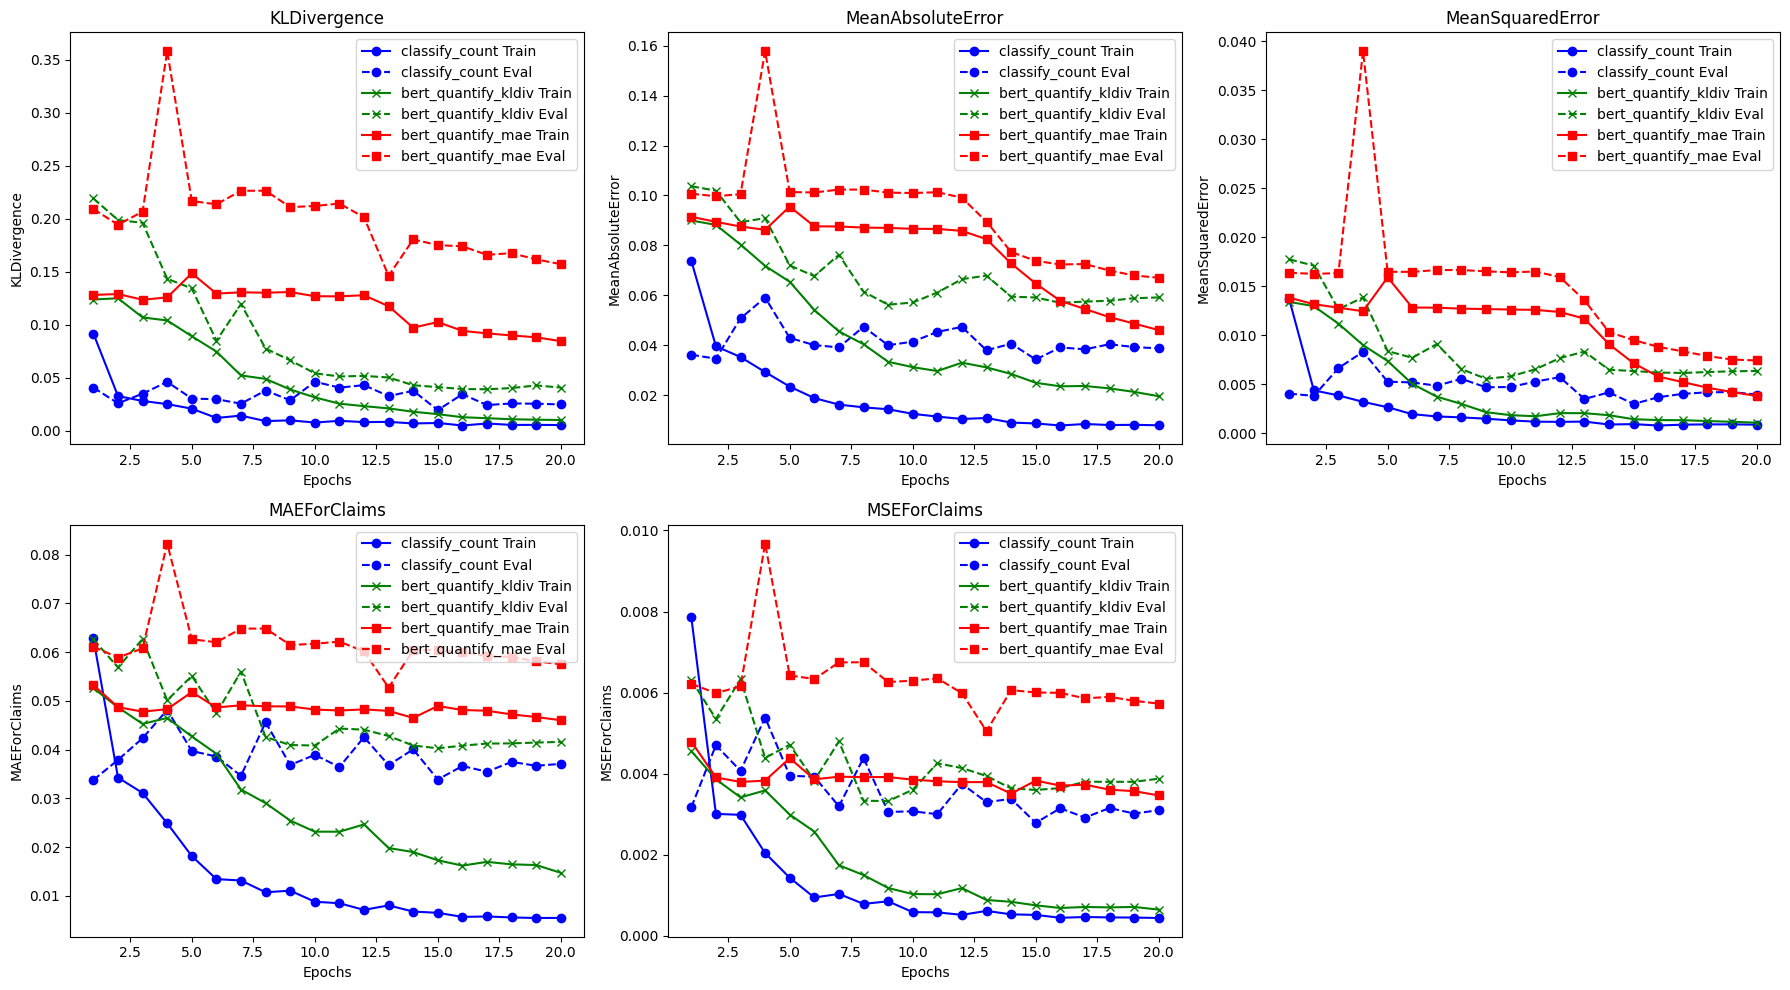

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data preparation
epochs_classify_count = range(1, len(history_classify_count['train_loss']) + 1)
epochs_bert_quantify = range(1, len(histories['bert_quantify_kldiv']['train_loss']) + 1)

metrics = ['KLDivergence', 'MeanAbsoluteError', 'MeanSquaredError', 'MAEForClaims', "MSEForClaims"]

# Define colors for consistency between train and eval plots
colors = {
    'classify_count': {'train': 'b', 'eval': 'b'},  # Blue for classify_count
    'bert_quantify_kldiv': {'train': 'g', 'eval': 'g'},  # Green for bert_quantify_kldiv
    'bert_quantify_mae': {'train': 'r', 'eval': 'r'},  # Red for bert_quantify_mae
}

# Adjust the number of subplots to include all metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten for easier indexing

# Plot Metrics
for i, metric in enumerate(metrics):
    # Plot classify_count
    axes[i].plot(epochs_classify_count, history_classify_count['train_metrics'][metric], label='classify_count Train', color=colors['classify_count']['train'], marker='o')
    axes[i].plot(epochs_classify_count, history_classify_count['eval_metrics'][metric], label='classify_count Eval', color=colors['classify_count']['eval'], linestyle='--', marker='o')

    # Plot bert_quantify_kldiv
    axes[i].plot(epochs_bert_quantify, histories['bert_quantify_kldiv']['train_metrics'][metric], label='bert_quantify_kldiv Train', color=colors['bert_quantify_kldiv']['train'], marker='x')
    axes[i].plot(epochs_bert_quantify, histories['bert_quantify_kldiv']['eval_metrics'][metric], label='bert_quantify_kldiv Eval', color=colors['bert_quantify_kldiv']['eval'], linestyle='--', marker='x')

    # Plot bert_quantify_mae
    axes[i].plot(epochs_bert_quantify, histories['bert_quantify_mae']['train_metrics'][metric], label='bert_quantify_mae Train', color=colors['bert_quantify_mae']['train'], marker='s')
    axes[i].plot(epochs_bert_quantify, histories['bert_quantify_mae']['eval_metrics'][metric], label='bert_quantify_mae Eval', color=colors['bert_quantify_mae']['eval'], linestyle='--', marker='s')

    # Set titles and labels
    axes[i].set_title(metric)
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(metric)
    axes[i].legend()

# Hide any unused subplot (the 6th subplot in this case)
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()





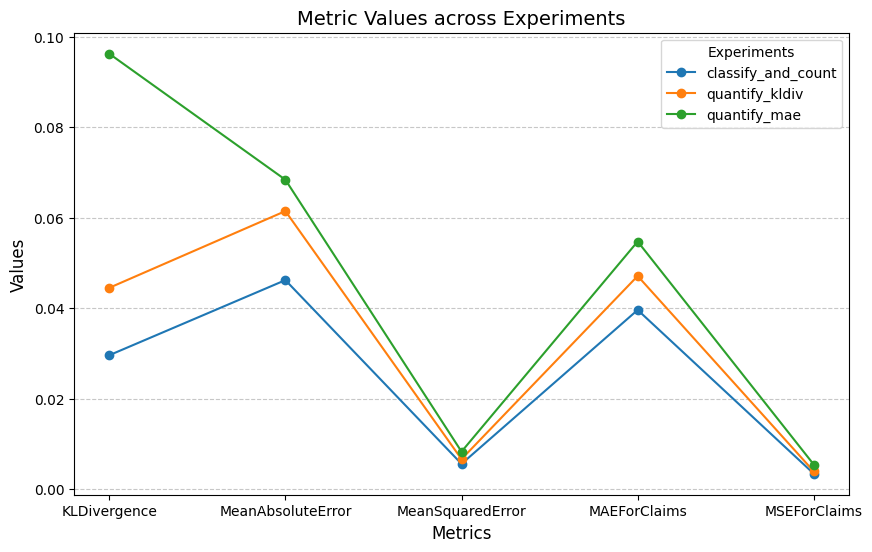

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Data preparation
metrics = list(eval_metrics.keys())
experiments = ['classify_and_count', 'quantify_kldiv', 'quantify_mae']
data = {
    'classify_and_count': eval_metrics,
    'quantify_kldiv': test_metrics['bert_quantify_kldiv'][1],
    'quantify_mae': test_metrics['bert_quantify_mae'][1]
}

# Values for each metric across experiments
values = {exp: [data[exp][metric] for metric in metrics] for exp in experiments}

# Plot
plt.figure(figsize=(10, 6))
for exp, vals in values.items():
    plt.plot(metrics, vals, marker='o', label=exp)

plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Metric Values across Experiments', fontsize=14)
plt.legend(title='Experiments', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
